# Portfolio optimization

# Set-up

First thing first, let me import the Python libraries first.

## Import libraries

In [1]:
import json
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf


import sys
sys.path.append('..')  # add ../src to sys.path
from FiDaL import (data as dta, plot)
from FiDaL.transformations import test_stationarity

In [2]:
# Read the credentials from credentials.json
with open('../config/credentials.json') as f:
    credentials = json.load(f)
    
    # Read the config from config.json
with open('../config/config.json') as f:
    config = json.load(f)

## Download and load the data

Selecting the right data period is crucial for the analysis. The following factors should be considered when selecting the data period:
- **Market changes**: Financial markets undergo structural changes over time. Regulations, economic conditions, technological advancements, and other factors can alter market dynamics. It's crucial to ensure that the data used is still representative of current conditions.
- **More Recent Data**: Some analysts prefer using more recent data (e.g., 3-5 years) on the premise that it better reflects the current market dynamics. Financial markets evolve, and the factors that influenced stock performance a decade ago may not be as relevant today.
- **Specific Asset Characteristics**: Different assets may require different look-back periods based on their volatility, liquidity, and the sectors they represent. For instance, technology stocks may behave differently compared to utility stocks over the same period.
- **Investment Horizon**: Align the data period with your investment horizon. If you are a long-term investor, using a longer historical period may be more appropriate. For shorter-term investments, consider using a shorter data period.
- **Statistical Significance:** Ensure that the data set is large enough to be statistically significant, reducing the risk of anomalies skewing the results.
- Be aware of **regime changes** (significant shifts in market trends or economic conditions) within your data period. These can significantly impact the relevance of historical data.
- **Consider using rolling windows** for your analysis. This technique involves continuously updating the time frame of the data used for the analysis (e.g., always using the most recent five years of data). This can provide a more dynamic view of how optimal weights change over time.

In [18]:
# Create an instance of the YFDataDownloader class
downloader = dta.make_data.YFDataDownloader(config, credentials=credentials)

# Get the data for the tickers to analyze using downloader.get_data()
print(config["data_source_params"])
data_downloaded = downloader.get_data(**config["data_source_params"])
data = data_downloaded[["Adj Close", "Volume"]]
del data_downloaded

{'tickers': ['AAPL'], 'start_date': '2021-01-01', 'end_date': '2024-12-31', 'interval': '1d'}


# Data Exploration

In [19]:
data.head(3)

,Adj Close,Volume
Date,,
2021-01-04,127.164154,143301900
2021-01-05,128.736389,97664900
2021-01-06,124.402931,155088000


In [20]:
data = (data.dropna(thresh=data.shape[1]//2)
        .rename(columns={"Adj Close": "price", "Volume": "volume"})
        .sort_index(axis=1))

data = dta.process.FinancialDataProcessor.compute_returns(data, column='price', log=True, apply_smoothing=True, smoothing_factor=1)

In [33]:
daily_returns = data["log_returns"]

expected_returns = daily_returns.mean()  # Calculate expected returns (mean of logarithmic returns)

print("\nExpected Returns:\n", expected_returns)


Expected Returns:
 0.0013386880856760374


The most important data cleaning steps for us are:
- **Missing Values**: Check for missing values and handle them appropriately. Missing values can cause issues with the analysis and may lead to incorrect conclusions. Common approaches for handling missing values include removing them, imputing them with a value (e.g., mean, median), or using a forward or backward fill.
- **Outliers**: Check for outliers and handle them appropriately. Outliers can skew the analysis and lead to incorrect conclusions. Common approaches for handling outliers include removing them or capping them at a certain value.
- **Data Types**: Ensure that the data types are correct. For instance, numerical values should be represented as floats or integers, and dates should be represented as date objects.
- **Duplicates**: Check for duplicate values and handle them appropriately. Duplicates can cause issues with the analysis and may lead to incorrect conclusions. Common approaches for handling duplicates include removing them or aggregating them.
- **Data Integrity**: Ensure that the data is correct and consistent. For instance, check that the data is in the expected range, and that the values are consistent with other data sources.
- **Data Format**: Ensure that the data is in the expected format. For instance, check that the data is in the expected units (e.g., dollars vs. cents), and that the values are consistent with other data sources.
- **Data Range**: Ensure that the data is within the expected range. For instance, check that the data is within the expected time period, and that the values are consistent with other data sources.
- **Data Granularity**: Ensure that the data is at the expected level of granularity. For instance, check that the data is at the expected frequency (e.g., daily, monthly, quarterly), and that the values are consistent with other data sources.

Let's apply all of these with the expection of outliers, and granulatiry because we can have outliners that are valid as we will see so these are things that we will need to check mostly manually, and granularity is already set to daily.

## Visual analzysis

### Volume vs price

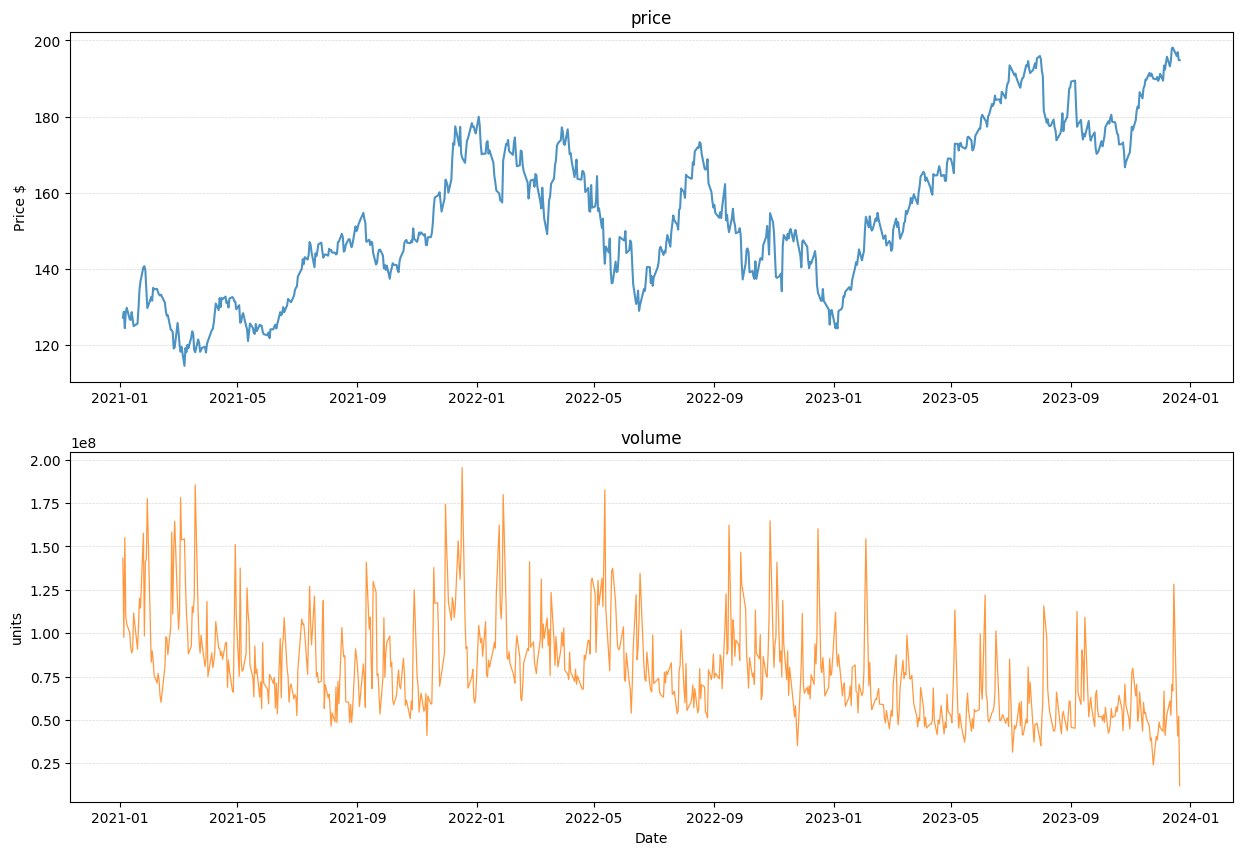

In [44]:
plot.adj_close_volume(data, columns=["price", "volume"], y_log=False)

### Moving Average

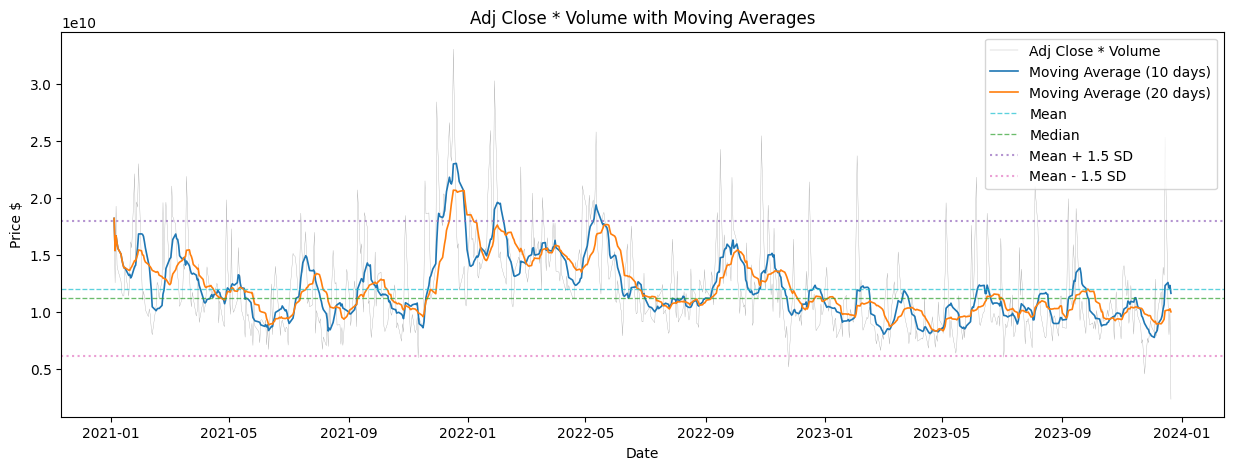

In [46]:
plot.moving_average(adj_close:=data["price"],
                    volume:=data["volume"],
                    window_sizes=[10, 20], include_stats=True, log_scale=False)

In [53]:
# Calculating volatility (annualized standard deviation of daily returns)
volatility = daily_returns.std() * (252**0.5) # Volatility is the annualized standard deviation of daily returns
correlation = daily_returns.dropna().corr(other=data["volume"].dropna())  # Calculate correlation between logarithmic returns and volume
daily_returns.describe(), volatility, correlation

(count    747.000000
 mean       0.001339
 std        0.000023
 min        0.001257
 25%        0.001326
 50%        0.001339
 75%        0.001353
 max        0.001452
 Name: log_returns, dtype: float64,
 0.0003727242918039268,
 -0.0638913125849046)

# 1. Component decomposition

## 1.1 Seasonal decomposition

<function matplotlib.pyplot.show(close=None, block=None)>

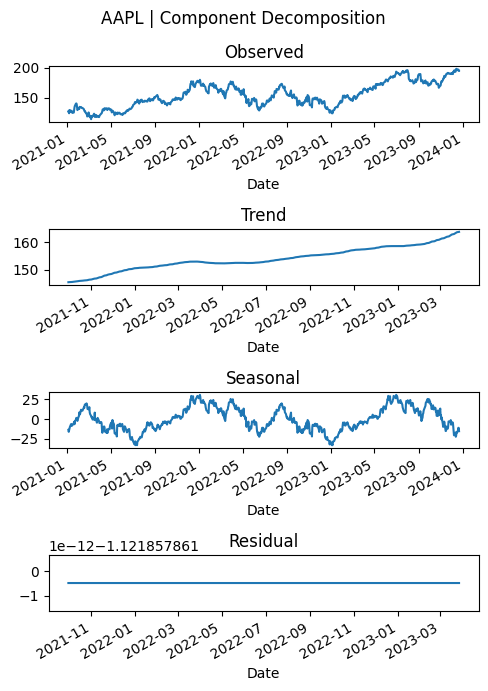

In [55]:
decomposed = seasonal_decompose(data["price"].interpolate(),
                                    model='additive', period=len(data) // 2)
fig = plot.decomposed_time_series(decomposed, ticker=ticker)
plt.show

## 1.2 Autocorrelation

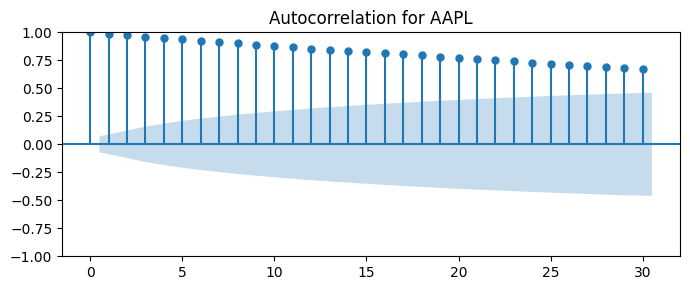

In [56]:
plot.autocorrelation(data["price"], title=ticker, lags=30, figsize=(7, 3))
plt.show()

## 1.3 Partial Autocorrelation

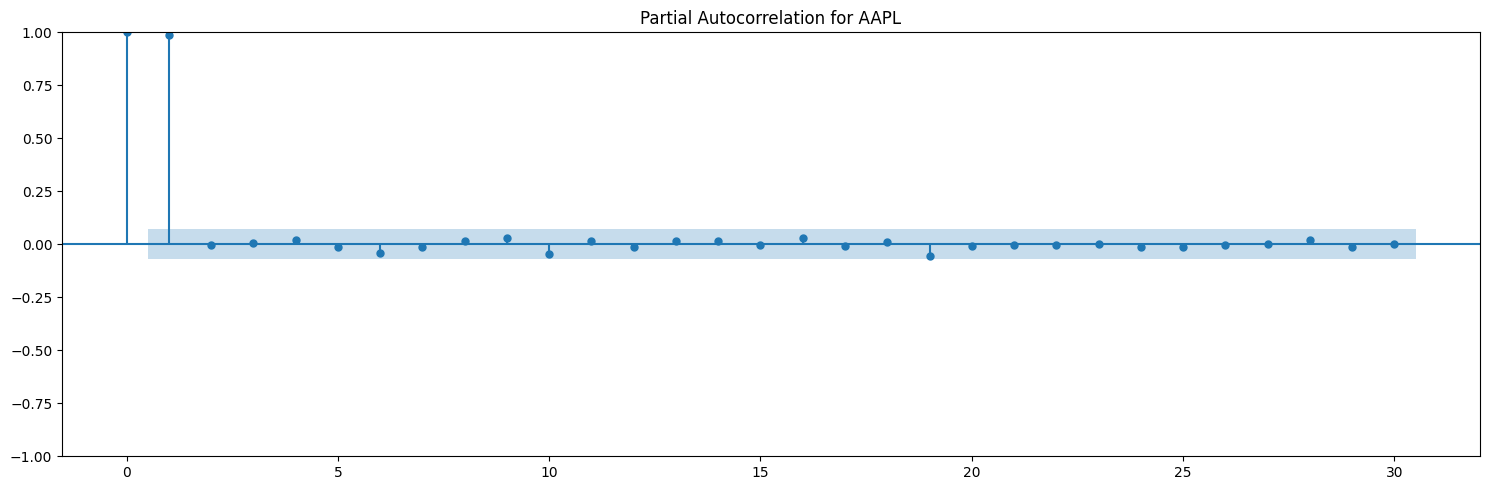

In [57]:
plot.partial_autocorrelation(data["price"], title=ticker, lags=30)
plt.show()

## 1.4 Test stationarity

In [59]:
print('\n',ticker, 'Dickey-Fuller Test for stationarity:')
_ = test_stationarity(timeseries=data["price"]
                        .interpolate(),
                        verbose=True)


 AAPL Dickey-Fuller Test for stationarity:
Results of Dickey-Fuller Test:
  Test Statistic: -1.5032
  p-value: 0.5319
  Interpretation: likely non-stationary.


To ensure that your time series data is stationary, a common technique is differencing. Differencing involves computing the differences between consecutive observations. This technique is particularly effective in removing trends and seasonality, which are common reasons for non-stationarity.

In [60]:
print('\n',ticker, 'Dickey-Fuller Test for stationarity:')
_ = test_stationarity(timeseries=data["price"]
                        .interpolate()
                        .diff().dropna(),
                        verbose=True)


 AAPL Dickey-Fuller Test for stationarity:
Results of Dickey-Fuller Test:
  Test Statistic: -20.3819
  p-value: 0.0000
  Interpretation: likely stationary.


# 2. Traditional Analysis

In [62]:
# 1. Determine Optimal Number of Lags
lag_acf = acf(timeseries:=data["price"].diff().dropna(), nlags=40)
lag_acf  # Inspect the lag_acf to choose short-term and long-term lags

array([ 1.00000000e+00,  4.88685241e-04, -5.61298001e-02, -9.65097394e-03,
        2.16814755e-03,  2.78558505e-02,  5.78221897e-03,  1.50420205e-03,
       -5.09487124e-02,  3.05950303e-02, -1.58194310e-02,  4.53627171e-02,
       -2.45967819e-02,  6.74573872e-03,  3.49129273e-03, -3.67891257e-02,
        5.39751244e-03, -6.18881373e-02,  5.05747946e-02,  8.30338193e-03,
       -1.20232013e-02, -9.97318357e-03, -1.76808332e-03,  2.80427814e-02,
        6.02312697e-03,  5.01195844e-03, -2.15582987e-02, -1.11445021e-02,
       -1.60787713e-03,  1.63591000e-02, -4.75577324e-02, -2.42988548e-02,
        1.49320364e-03, -4.18038141e-02,  2.68912513e-02,  1.88210633e-02,
       -2.02792960e-02, -7.36255294e-03,  2.62998418e-02, -8.34253042e-02,
       -6.75800966e-02])

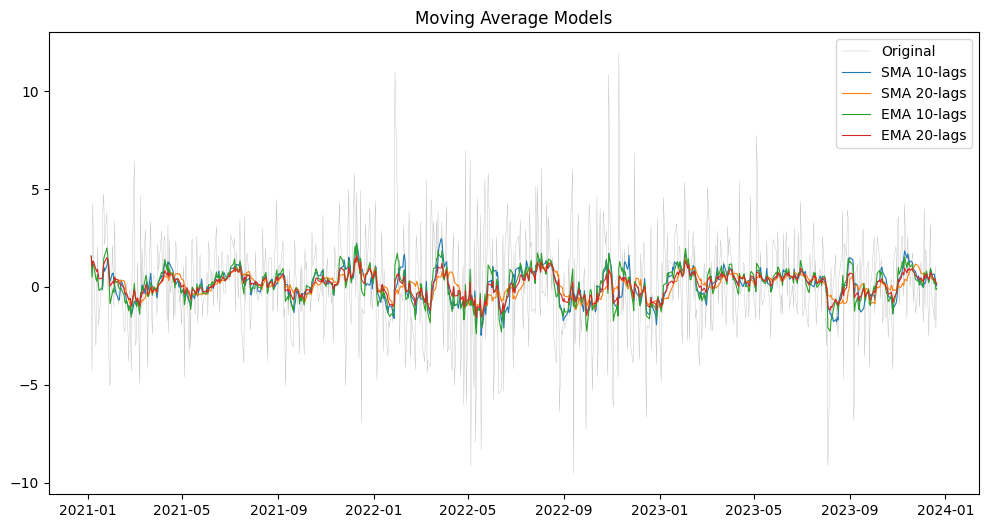

RMSE - SMA Short: 2.5108245252265626
RMSE - SMA Long: 2.5683928410095236
RMSE - EMA Short: 2.276638857844639
RMSE - EMA Long: 2.447097793817697


In [64]:
# 2. Plot SMA and EMAs
plot.analyze_moving_averages(timeseries,
                        short_term_lag=10,
                        long_term_lag=20)